In [1]:
import _config

%cd ..

from tools.post_search import get_archive_best_models
from search_space import get_search_space

import matplotlib.pyplot as plt
import numpy as np
import json
import os
import re

BASE_DIR = "nas-results"


/home/fsahli/vvcastro/continual-nas


Get the experiment data:

In [2]:
DATASET_NAME = "cifar10"
MODEL_TYPE = "growing"
SEED_ID = 42


def read_model_data(model_dir: str):
    history_path = os.path.join(model_dir, "history.json")
    return json.load(open(history_path))

def get_best_archive(archives_dir: str):

    # Get the last available archive
    experiment_archives = os.listdir(os.path.join(archives_dir, "archives"))
    experiment_archives.sort(key=lambda name: int(re.search(r"\d+", name).group()))
    last_archive = experiment_archives[-1]
    print(f"Last archive: {last_archive}")

    # Read the archive data as a .json file
    archive_path = os.path.join(archives_dir, "archives", last_archive)
    archive_data = json.load(open(archive_path))
    return archive_data


def read_single_objective_data(dataset: str, model_type: str, seed: int, n_best=5):

    # Build the experiments dir
    EXPERIMENT_TYPE_ARCHIVE_DIR = os.path.join(
        BASE_DIR,
        f"efficient-{dataset}",
        f"{model_type}-seed{seed}",
        "single-objective",
    )

    # Read the archive
    single_objective_archive = get_best_archive(EXPERIMENT_TYPE_ARCHIVE_DIR)

    # Retrive the best models
    archive_models = [datum["sample"] for datum in single_objective_archive]
    archive_metrics = np.stack([datum["metrics"] for datum in single_objective_archive])

    # Get the best models from the archive
    best_models, best_metrics = get_archive_best_models(
        archive_models, archive_metrics, n_best=n_best
    )

    # Add new axis in best metrics
    flatness_metrics = np.zeros((n_best, 1))

    # Get the encoded models
    search_space = get_search_space(family="mobilenetv3", fixed=model_type=="fixed")
    for i, model in enumerate(best_models):
        model_encoding = search_space.encode(model)
        model_name = "".join(map(str, model_encoding)) + f"-{seed}"

        # Read the model data
        model_dir = os.path.join(
            BASE_DIR,
            f"efficient-{dataset}",
            f"{model_type}-seed{seed}",
            "models",
            model_name
        )
        model_history = read_model_data(model_dir)

        # Get the flatness
        final_training_metrics = model_history["training_metrics"]["validation"]
        flatness = [ task["flatness"][-1] for task in final_training_metrics.values()]
        mean_flatness = np.mean(flatness)

        # Add the flatness to the metrics
        flatness_metrics[i] = 100 *mean_flatness

    # Concatenate the metrics
    best_metrics = np.concatenate([best_metrics, flatness_metrics], axis=1)

    return best_models, best_metrics

def read_multi_objective_data(dataset: str, model_type: str, seed: int, n_best=5):
    EXPERIMENT_TYPE_ARCHIVE_DIR = os.path.join(
        BASE_DIR,
        f"efficient-{dataset}",
        f"{model_type}-seed{seed}",
        "multi-objective",
    )

    # Read the archive
    multi_objective_archive = get_best_archive(EXPERIMENT_TYPE_ARCHIVE_DIR)

    # Retrive the best models
    archive_models = [datum["sample"] for datum in multi_objective_archive]
    archive_metrics = np.stack([datum["metrics"] for datum in multi_objective_archive])

    # Get the best models from the archive
    best_models, best_metrics = get_archive_best_models(
        archive_models, archive_metrics, n_best=2*n_best
    )

    # Given the OFA having repeated models, we drop duplicates on metrics
    _, unique_indices = np.unique(best_metrics[:, :2], axis=0, return_index=True)
    best_models = best_models[unique_indices]
    best_metrics = best_metrics[unique_indices]

    # Sort by the accuracy metric
    sorted_metrics_indices = np.argsort(best_metrics[:, 0])
    best_models = best_models[sorted_metrics_indices[::-1]]
    best_metrics = best_metrics[sorted_metrics_indices[::-1]]

    return best_models, best_metrics


Get the best models from the archive:

Last archive: iter_13.archive
Last archive: iter_30.archive


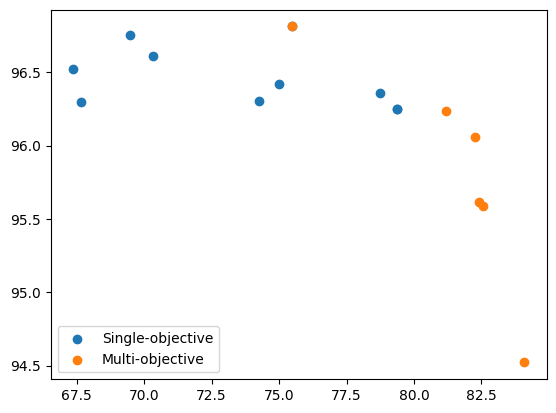

In [3]:
single_objective_models, single_objective_metrics = read_single_objective_data(DATASET_NAME, MODEL_TYPE, SEED_ID, n_best=10)
multi_objective_models, multi_objective_metrics = read_multi_objective_data(DATASET_NAME, MODEL_TYPE, SEED_ID, n_best=5)

# Scatter plot of the flatness vs the accuracy
plt.scatter(single_objective_metrics[:, 1], single_objective_metrics[:, 0], label="Single-objective")
plt.scatter(multi_objective_metrics[:, 1], multi_objective_metrics[:, 0], label="Multi-objective")
plt.legend(loc="lower left")
plt.show()

In [4]:
print("Single-objective")
print(single_objective_metrics[:5].mean(axis=0))
print(single_objective_metrics[:5].std(axis=0))

print()

print("Multi-objective")
print(multi_objective_metrics[:5].mean(axis=0))
print(multi_objective_metrics[:5].std(axis=0))

Single-objective
[96.62431066 71.53492833]
[0.14591539 3.1819524 ]

Multi-objective
[96.06194039 80.7813392 ]
[0.45168693 2.69029843]


Get train the models and the get the rest of the metrics:

In [7]:
import subprocess

def test_model(test_dir: str, model):
    search_space = get_search_space("mobilenetv3", MODEL_TYPE == "fixed")

    # Build the evaluator run params
    model_encoding = search_space.encode(model)
    params = [
        "python",
        "scripts-nas/_tester.py",
        "--experiment_dir",
        str(test_dir),
        "--model_encoding",
        *map(str, model_encoding),
        "--dataset",
        str(DATASET_NAME),
        "--n_tasks",
        "5",
        "--epochs_per_task",
        "1",
        "--architecture",
        str("expandable" if MODEL_TYPE == "growing" else "fixed"),
        "--random_seed",
        str(SEED_ID),
    ]

    # Execute the script
    subprocess.run(params, check=True)


# Results dir
FLATNESS_TEST_RESULTS_DIR = os.path.join(
    "nas-tester",
    f"efficient-{DATASET_NAME}",
    "flatness",
    f"{MODEL_TYPE}-seed{SEED_ID}",
)

Evaluate the models as describe in the thesis:

In [8]:
best_acc_single_model = single_objective_models[0]
test_model(FLATNESS_TEST_RESULTS_DIR, best_acc_single_model)

# Get the model with the best flatness
best_flatness_multi_model = multi_objective_models[-1]
test_model(FLATNESS_TEST_RESULTS_DIR, best_flatness_multi_model)

# Get the model with the best trade-off
best_tradeoff_multi_model = multi_objective_models[2]
test_model(FLATNESS_TEST_RESULTS_DIR, best_tradeoff_multi_model)

Files already downloaded and verified


Training: 100%|██████████| 313/313 [00:15<00:00, 19.60it/s]



Training metrics:
	Loss: 0.5799 ± 0.3460
	accuracy: 0.8046 ± 0.1179


Training: 100%|██████████| 313/313 [00:14<00:00, 22.02it/s]



Training metrics:
	Loss: 0.5790 ± 0.3775
	accuracy: 0.8026 ± 0.1276


Training: 100%|██████████| 313/313 [00:13<00:00, 23.56it/s]



Training metrics:
	Loss: 0.5615 ± 0.3505
	accuracy: 0.8087 ± 0.1202


Training: 100%|██████████| 313/313 [00:12<00:00, 24.21it/s]



Training metrics:
	Loss: 0.5750 ± 0.3688
	accuracy: 0.8063 ± 0.1313


Training: 100%|██████████| 313/313 [00:12<00:00, 25.97it/s]



Training metrics:
	Loss: 0.5728 ± 0.3601
	accuracy: 0.8051 ± 0.1212


Training: 100%|██████████| 313/313 [00:13<00:00, 23.73it/s]



Training metrics:
	Loss: 0.5542 ± 0.3487
	accuracy: 0.8139 ± 0.1175


Training: 100%|██████████| 313/313 [00:12<00:00, 24.85it/s]



Training metrics:
	Loss: 0.3906 ± 0.1688
	accuracy: 0.8700 ± 0.0588


Training: 100%|██████████| 313/313 [00:14<00:00, 21.50it/s]



Training metrics:
	Loss: 0.3244 ± 0.1686
	accuracy: 0.8911 ± 0.0550


Training: 100%|██████████| 313/313 [00:10<00:00, 29.60it/s]



Training metrics:
	Loss: 0.3011 ± 0.1572
	accuracy: 0.9014 ± 0.0524


Training: 100%|██████████| 313/313 [00:09<00:00, 31.42it/s]



Training metrics:
	Loss: 0.2631 ± 0.1432
	accuracy: 0.9122 ± 0.0463
Files already downloaded and verified


Training: 100%|██████████| 313/313 [00:07<00:00, 41.20it/s]



Training metrics:
	Loss: 0.5573 ± 0.3685
	accuracy: 0.8117 ± 0.1241


Training: 100%|██████████| 313/313 [00:07<00:00, 42.89it/s]



Training metrics:
	Loss: 0.5718 ± 0.3708
	accuracy: 0.8100 ± 0.1252


Training: 100%|██████████| 313/313 [00:07<00:00, 41.14it/s]



Training metrics:
	Loss: 0.5522 ± 0.3547
	accuracy: 0.8171 ± 0.1214


Training: 100%|██████████| 313/313 [00:07<00:00, 43.30it/s]



Training metrics:
	Loss: 0.5585 ± 0.3583
	accuracy: 0.8050 ± 0.1276


Training: 100%|██████████| 313/313 [00:07<00:00, 42.42it/s]



Training metrics:
	Loss: 0.5524 ± 0.3507
	accuracy: 0.8108 ± 0.1255


Training: 100%|██████████| 313/313 [00:07<00:00, 41.12it/s]



Training metrics:
	Loss: 0.5434 ± 0.3523
	accuracy: 0.8219 ± 0.1183


Training: 100%|██████████| 313/313 [00:07<00:00, 41.10it/s]



Training metrics:
	Loss: 0.3691 ± 0.1768
	accuracy: 0.8792 ± 0.0591


Training: 100%|██████████| 313/313 [00:07<00:00, 40.92it/s]



Training metrics:
	Loss: 0.3060 ± 0.1573
	accuracy: 0.9018 ± 0.0535


Training: 100%|██████████| 313/313 [00:07<00:00, 41.08it/s]



Training metrics:
	Loss: 0.2877 ± 0.1479
	accuracy: 0.9019 ± 0.0523


Training: 100%|██████████| 313/313 [00:09<00:00, 32.35it/s]



Training metrics:
	Loss: 0.2561 ± 0.1558
	accuracy: 0.9153 ± 0.0528
Files already downloaded and verified


Training: 100%|██████████| 313/313 [00:06<00:00, 49.25it/s]



Training metrics:
	Loss: 0.5793 ± 0.3480
	accuracy: 0.8048 ± 0.1185


Training: 100%|██████████| 313/313 [00:06<00:00, 51.75it/s]



Training metrics:
	Loss: 0.5735 ± 0.3631
	accuracy: 0.8074 ± 0.1283


Training: 100%|██████████| 313/313 [00:06<00:00, 51.81it/s]



Training metrics:
	Loss: 0.5645 ± 0.3546
	accuracy: 0.8138 ± 0.1228


Training: 100%|██████████| 313/313 [00:06<00:00, 51.76it/s]



Training metrics:
	Loss: 0.5658 ± 0.3637
	accuracy: 0.8080 ± 0.1239


Training: 100%|██████████| 313/313 [00:06<00:00, 51.83it/s]



Training metrics:
	Loss: 0.5649 ± 0.3470
	accuracy: 0.8046 ± 0.1225


Training: 100%|██████████| 313/313 [00:06<00:00, 51.74it/s]



Training metrics:
	Loss: 0.5585 ± 0.3529
	accuracy: 0.8098 ± 0.1186
Applying model expansion...


Training: 100%|██████████| 313/313 [00:07<00:00, 41.11it/s]



Training metrics:
	Loss: 0.3599 ± 0.1635
	accuracy: 0.8789 ± 0.0594


Training: 100%|██████████| 313/313 [00:06<00:00, 51.13it/s]



Training metrics:
	Loss: 0.3173 ± 0.1556
	accuracy: 0.8950 ± 0.0534
Applying model expansion...


Training: 100%|██████████| 313/313 [00:07<00:00, 40.47it/s]



Training metrics:
	Loss: 0.2749 ± 0.1455
	accuracy: 0.9106 ± 0.0508
Applying model expansion...


Training: 100%|██████████| 313/313 [00:07<00:00, 40.41it/s]



Training metrics:
	Loss: 0.2586 ± 0.1354
	accuracy: 0.9146 ± 0.0477


Get the metrics from the test models:

In [165]:
from continual_learning.continual_metrics import compute_continual_metrics
from typing import Dict, Any, List

def get_model_metrics(model, test_dir: str, n_tasks: int = 10):
    search_space = get_search_space("mobilenetv3", MODEL_TYPE == "fixed")

    # Build the evaluator run params
    model_encoding = search_space.encode(model)
    model_name = "".join(map(str, model_encoding)) + f"-{SEED_ID}"

    # Read the model data
    model_history = read_model_data(os.path.join(test_dir + f"-{n_tasks}", "models", model_name))
    continual_metrics = compute_continual_metrics(model_history)
    return continual_metrics

def plot_experiment_data(
    display_names: List[str],
    experiments: List[Dict[str, Any]],
    std_multiplier: float = 0.25,
):
    """
    Plot the experiment data.
    """
    fig = plt.figure(figsize=(30, 7), dpi=300)
    axs = fig.subplots(1, 5).flatten()

    # Get the correct colors
    colors = plt.cm.tab10.colors

    # Get the metrics we will be plotting
    metric_names = experiments[0].keys()

    # Aggregate the metrics accross the different initialisations
    for cidx, (display_name, experiment) in enumerate(zip(display_names, experiments)):
        for i, metric_name in enumerate(metric_names):
            plot_data = np.array(experiment[metric_name])
            ax = axs[i]

            # Number of evaluated metrics
            valid_indices = ~np.isnan(plot_data)
            valid_mean = plot_data[valid_indices]

            x_ticks = np.arange(len(plot_data))[valid_indices] + 1

            # Format the name the metric to form a title
            metric_title = metric_name.replace("_", " ").capitalize()

            # Plot a specific subplot for the metric
            ax.set_title(metric_title)

            # Plot the curves and th std
            ax.plot(
                x_ticks,
                valid_mean,
                marker="s",
                linestyle="-" if len(display_names) <= 3 else "--",
                markersize=6,
                color=colors[cidx],
                label=display_name,
            )

            ax.set_xticks(x_ticks, x_ticks)
            ax.set_xlabel("Task")
            ax.legend(loc="best")

    plt.tight_layout()
    plt.show()


In [171]:
best_acc_single_metrics = get_model_metrics(
    best_acc_single_model,
    FLATNESS_TEST_RESULTS_DIR,
    n_tasks=5,
)
best_flatness_multi_metrics = get_model_metrics(
    best_flatness_multi_model,
    FLATNESS_TEST_RESULTS_DIR,
    n_tasks=5,
)
best_tradeoff_multi_metrics = get_model_metrics(
    best_tradeoff_multi_model,
    FLATNESS_TEST_RESULTS_DIR,
    n_tasks=5,
)

Plot the metrics:

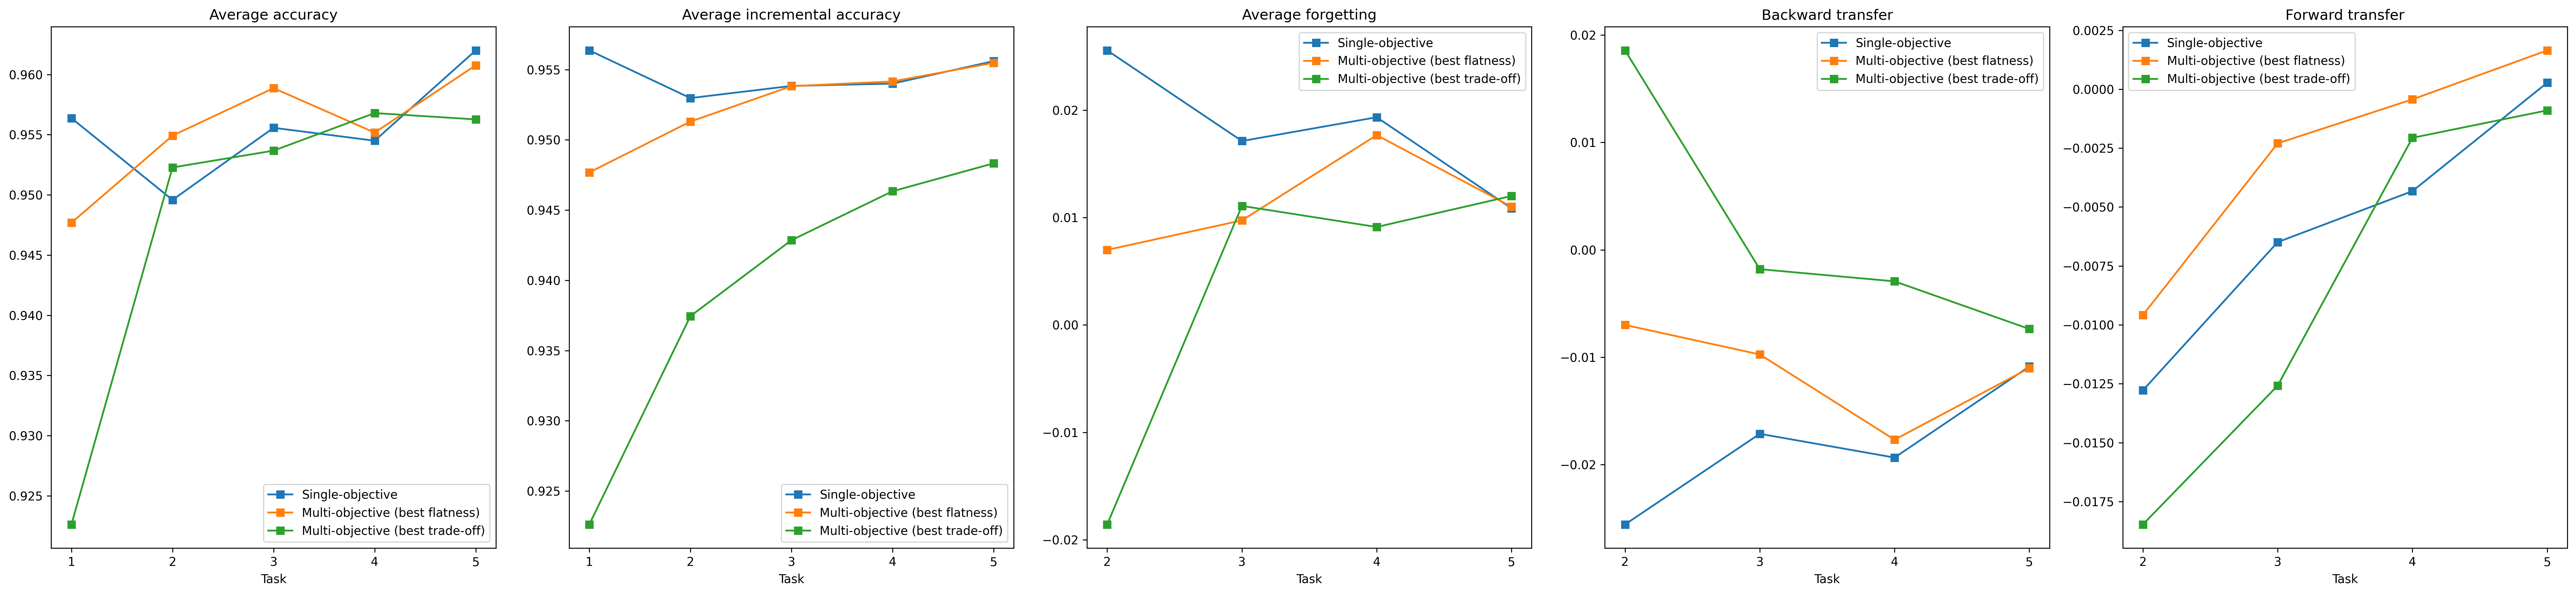

In [172]:
plot_experiment_data(
    display_names=["Single-objective", "Multi-objective (best flatness)", "Multi-objective (best trade-off)"],
    experiments=[best_acc_single_metrics, best_flatness_multi_metrics, best_tradeoff_multi_metrics],
    std_multiplier=0.5,
)

In [159]:
a = best_flatness_multi_metrics['average_forgetting'][-1]
b = best_tradeoff_multi_metrics["average_forgetting"][-1]

print(np.std([a, b]))
print(b)



0.0004992014728486538
0.012005791068077087


In [155]:
best_acc_single_metrics["average_forgetting"][-1]

0.010857628658413887

In [176]:
print(np.mean([4.61, 3.37, 3.56]))
print(np.std([4.61, 3.37, 3.56]))



3.846666666666667
0.5453031776503376
